In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import joblib as jb
from glob import glob
from preprocessing import *

# 1.0 - Reading Data

In [4]:
path = Path('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif')
path_bat = '/home/vinicius/Área de Trabalho/Faculdade/TCC/data/DADOS_TCC_BIANCA/02.Dados_Processados/02.XYZ/BATIMETRIA_PROCESSADA_BABITONGA_2018_DHN_WGS84_UTM22S.xyz'

In [5]:
# Rhos images
rhos_list = [e for e in glob('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/*.tif') if 'rhos' in str(e)]

In [6]:
# Array of images
tiff_array = [tifffile.TiffFile(path).asarray() for path in rhos_list]

In [7]:
# Get data from tiff header and save on dict
tiff = tifffile.TiffFile(rhos_list[0])
aux_dict = dict()
for page in tiff.pages:
    for tag in page.tags:
        aux_dict[tag.name] = tag.value

scale_x = aux_dict['ModelPixelScaleTag'][0]
scale_y = aux_dict['ModelPixelScaleTag'][1]
start_value_x = aux_dict['ModelTiepointTag'][3]
start_value_y = aux_dict['ModelTiepointTag'][4]

In [10]:
start_value_y

7117780.0

In [9]:
# Read bathymetry dataframe
df = pd.read_csv(path_bat, sep=' ', header=None)
df.columns = ['x', 'y', 'z']
df

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98
2,720508.07,7089857.12,1.98
3,720508.19,7089857.09,1.97
4,720508.31,7089857.07,1.98
...,...,...,...
557239,720868.85,7107250.49,3.41
557240,720868.95,7107250.55,3.41
557241,720869.05,7107250.60,3.41
557242,720869.14,7107250.65,3.41


In [10]:
rhos_list

['../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_740.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_704.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_783.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_833.tif',
 '../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_443.tif']

In [11]:
# Create reflectance data for all bands and append to dataframe columns
for i, band in enumerate(tiff_array):
    column_name = 'reflectance_{}'.format(i)
    aux = list()
    for i, row in enumerate(df.itertuples()):
        x = row[1]
        y = row[2]
        z = row[3]
        pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
        aux.append(band[pixel[1]][pixel[0]])
        
    df[column_name] = aux

# 2.0 - Modeling

In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

In [237]:
features = df.drop(['z', 'y', 'x'], axis=1)
target = df['z']

In [238]:
# Split data into train and test
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.5)

In [239]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((278622, 8), (278622,), (278622, 8), (278622,))

In [240]:
# First baseline model
lgbm = LGBMRegressor(n_estimators=500)

In [53]:
# Fit the model
lgbm.fit(X_train, y_train)

LGBMRegressor(n_estimators=500)

In [54]:
# Apply validation data to predict method
p = lgbm.predict(X_val)

# 2.1 - Scores Baseline

In [55]:
r2_score(y_val, p)

0.8979660065989385

In [180]:
print('MSE:', mean_squared_error(y_val, p)) 
print('MAE:', mean_absolute_error(y_val, p))
print('MedAE:', median_absolute_error(y_val, p))

MSE: 1.5821082675404659
MAE: 0.9003092460082408
MedAE: 0.6619038929870058


# 2.2 - Bayesian Optimization

In [56]:
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000)] # n_estimator


In [57]:
from skopt import forest_minimize

def tune_lgbm(args):
    lr = args[0]
    max_depth = args[1]
    min_child_samples = args[2]
    subsample = args[3]
    colsample_bytree = args[4]
    n_estimators = args[5]
    
    mdl = LGBMRegressor(learning_rate=lr, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators)
    mdl.fit(X_train, y_train)
    p = mdl.predict(X_val)
    print(r2_score(y_val, p))
    
    return -r2_score(y_val, p)

In [58]:
res = forest_minimize(tune_lgbm, space, random_state=160000, n_random_starts=20, n_calls=50, verbose=0)

0.5810931121243449
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.7501886657340556
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.6987614913331419
0.3825602803310234
0.4408767919951665
0.6560283926767049
0.543215864402514
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.6556890787174623
0.45284927788830265
0.5827639564091305
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.0793886732331871
0.546689947353783
0.6667603149057999
0.6134208435778127
0.7425502205574497
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.5943114138931671
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.8514635080223554
0.6405815141359533
0.25830053481083515
[LightGBM] [Warning] Accura

In [60]:
# best hyperparameters
res['x']

[0.09740262475085597, 8, 19, 0.2518783353639487, 0.9892916499919282, 987]

In [ ]:
lr = res['x'][0]
max_depth = res['x'][1]
min_child_samples = res['x'][2]
subsample = res['x'][3]
colsample_bytree = res['x'][4]
n_estimators = res['x'][5]

In [69]:
hyper = {
    'lr': res['x'][0],
    "max_depth": res['x'][1],
    "min_child_samples": res['x'][2],
    "subsample": res['x'][3],
    'colsample_bytree': res['x'][4],
    'n_estimators': res['x'][5]
}

In [70]:
mdl = LGBMRegressor(learning_rate=hyper['lr'], max_depth=hyper['max_depth'], 
                    min_child_samples=hyper['min_child_samples'], subsample=hyper['subsample'], 
                    colsample_bytree=hyper['colsample_bytree'], n_estimators=hyper['n_estimators'])

In [75]:
mdl.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMRegressor(colsample_bytree=0.9892916499919282,
              learning_rate=0.09740262475085597, max_depth=8,
              min_child_samples=19, n_estimators=987,
              subsample=0.2518783353639487)

In [76]:
p = mdl.predict(X_val)

In [77]:
r2_score(y_val, p)

0.9401299647792786

In [81]:
import joblib as jb

In [82]:
# Save model weights
jb.dump(mdl, 'models/lgbm_baseline.pkl.z')

['models/lgbm_baseline.pkl.z']

# 2.3 - Cross Validation

In [111]:
from sklearn.model_selection import KFold

def cross_validation():
    global hyper
    k_fold_splits = {}
    kf = KFold(n_splits=10, shuffle=True)
    for i, (lines_train, lines_val) in enumerate(kf.split(features)):
        X_train = features.iloc[lines_train]
        X_val = features.iloc[lines_val]
        y_train = target.iloc[lines_train]
        y_val = target.iloc[lines_val]
        
        mdl = LGBMRegressor(learning_rate=hyper['lr'], max_depth=hyper['max_depth'], 
                    min_child_samples=hyper['min_child_samples'], subsample=hyper['subsample'], 
                    colsample_bytree=hyper['colsample_bytree'], n_estimators=hyper['n_estimators'])
        mdl.fit(X_train, y_train)
        p = mdl.predict(X_val)
        score = r2_score(y_val, p)
        
        k_fold_splits[f'k_fold_{i}'] = score
        
    return k_fold_splits

In [112]:
scores = cross_validation()

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

In [113]:
scores

{'k_fold_0': 0.939548465359788,
 'k_fold_1': 0.9377885540768874,
 'k_fold_2': 0.9402362616528233,
 'k_fold_3': 0.940778060182846,
 'k_fold_4': 0.9386476311385993,
 'k_fold_5': 0.9405571129912291,
 'k_fold_6': 0.9394825953575132,
 'k_fold_7': 0.9403352893882927,
 'k_fold_8': 0.9396653629866762,
 'k_fold_9': 0.9416083975176831}

# 3.0 - Output RGB

In [124]:
from sklearn.preprocessing import normalize

In [115]:
b4 = tifffile.TiffFile('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif')
b3 = tifffile.TiffFile('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif')
b2 = tifffile.TiffFile('../data/DADOS_TCC_BIANCA/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif')

In [166]:
rgb = np.dstack((b4.asarray(), b3.asarray(), b2.asarray())) + 0.1
bgr = np.dstack((b2.asarray(), b3.asarray(), b4.asarray())) + 0.1

In [168]:
rgb.clip(0, 1).min(), rgb.clip(0, 1).max()

(0.009969793, 1.0)

In [169]:
bgr.clip(0, 1).min(), bgr.clip(0, 1).max()

(0.009969793, 1.0)

In [170]:
rgb_clip = rgb.clip(0, 1)
bgr_clip = bgr.clip(0, 1)

In [171]:
from scipy import stats

In [172]:
bgr_output = (bgr_clip * 255.99).astype(np.uint8)

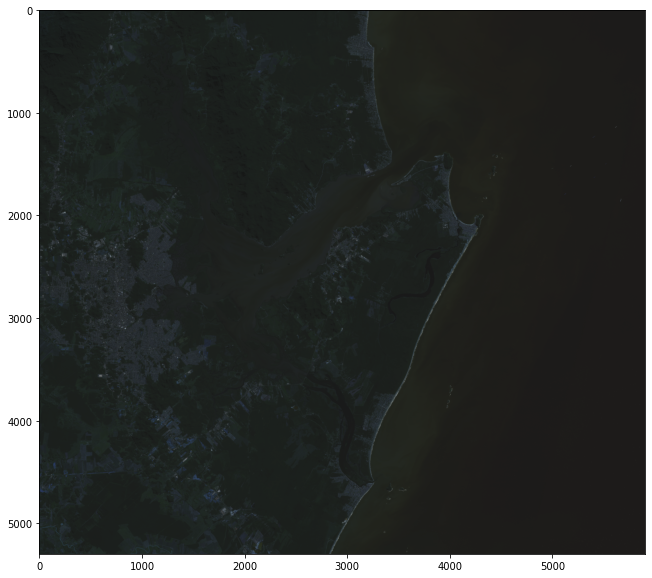

In [173]:
plt.figure(figsize=(12, 10))
plt.imshow(bgr_output)

In [177]:
import cv2
cv2.imwrite('photos/output_image.png', bgr_output)

True